## EDA

In [1]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import calplot
from datetime import datetime

# statistics
import scipy
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# working with files
import sys
import os
from pathlib import Path
import csv

# to off warnings
import warnings
warnings.filterwarnings('ignore')

#clusterization
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# data preprocessing
from itertools import product
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# using ray engine for parallel calculation(for oprimization)

%env MODIN_ENGINE=ray
import modin.pandas as mpd
pd.DEFAULT_NPARTITIONS = 6

env: MODIN_ENGINE=ray


Read data

In [3]:
%%time

# get directory path
dirpath = os.getcwd()

# set the data path
clean_data_path = Path(dirpath) / 'data' /'clean_data'
print(clean_data_path)
print(type(clean_data_path))

# initiate dict for data
data = {}

# load data to dict
for file_path in clean_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = mpd.read_csv(file_path)
        print(file_path.stem)

C:\Repository\DS-Intership\data\clean_data
<class 'pathlib.WindowsPath'>


2023-10-24 14:02:18,657	INFO worker.py:1621 -- Started a local Ray instance.


items
item_categories
sales_train
sample_submission
shops
test
CPU times: total: 422 ms
Wall time: 8.51 s


### Dtale

In [4]:
# import dtale

# df = pd.DataFrame(data['sales_train'], columns=data['sales_train'].columns, index=data['sales_train'].index)
# df.year_month = pd.to_datetime(df.year_month)

# # Assigning a reference to a running D-Tale process
# d = dtale.show(df)

# d.open_browser()

In [5]:
# d.kill()

### Item categories

In [6]:
# we can try to check what categories have low/high sales
data['item_categories'].head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

What item's categories have low/high sales?

In [7]:
sales_data = data['sales_train'].merge(
        data['items'], how='left', on='item_id'
        ).merge(
                data['item_categories'], how='left', on='item_category_id'
                ).drop(columns=['shop_id', 'year_month', 'item_name'])
sales_data.head(2)

date  date_block_num  item_id  item_price  item_cnt_day  \
0  2013-01-02               0    22154      999.00          1.00   
1  2013-01-03               0     2552      899.00          1.00   

   item_category_id item_category_name  
0                37     Кино - Blu-Ray  
1                58     Музыка - Винил

In [8]:
# data selection
g = mpd.DataFrame(sales_data.groupby(['item_category_id'])['item_cnt_day'].agg(sum))\
                 .rename(columns={'item_cnt_day':'category_sales'}).reset_index()\
                 .merge(data['item_categories'], on='item_category_id', how='left')\
                 .sort_values(by='category_sales', ascending=False)

g["type_code"] = g.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
g["split"] = g.item_category_name.apply(lambda x: x.split("-"))
g["subtype"] = g.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
g = g.drop(columns=['split'])
type_code_g = g.groupby('type_code')['category_sales'].agg(sum).sort_values(ascending=False)
subtype_g = g.groupby('subtype')['category_sales'].agg(sum).sort_values(ascending=False)

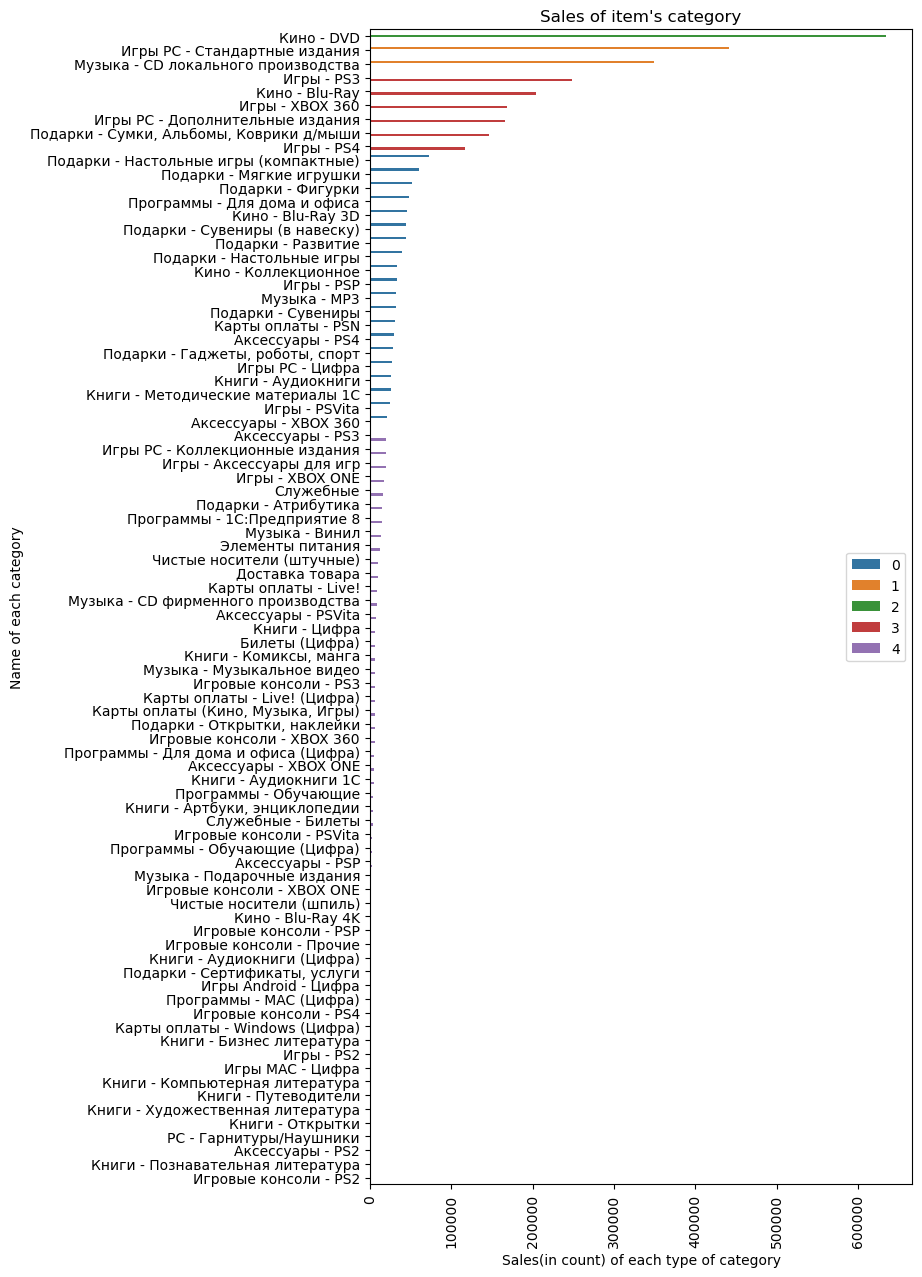

In [9]:
#clusterization
km = KMeans(n_clusters= 5, random_state=42, n_init="auto").fit(g.category_sales.to_numpy().reshape(-1, 1))

# visualization
plt.figure(figsize=(7, 15))
ax = sns.barplot(y=g.item_category_name.to_numpy(), x=g.category_sales.to_numpy(), hue= km.labels_)
ax.set(ylabel='Name of each category', xlabel='Sales(in count) of each type of category', title="Sales of item's category")
ax.tick_params(axis='x', rotation=90)
plt.show()

#saving results of clazterization
labels = mpd.DataFrame(km.labels_, columns=['category_cluster_id'])
item_category_clusters = mpd.concat([g.drop(columns=['category_sales',
                                                     'type_code',
                                                     'subtype',
                                                     'item_category_name'
                                                    ]), labels], axis=1)

A few item categories have huge sales when other have poor sales, we can higlight the categories with the highest sales using clusterization. Also we can additionaly check sales of categories in split by type code and subtype. 

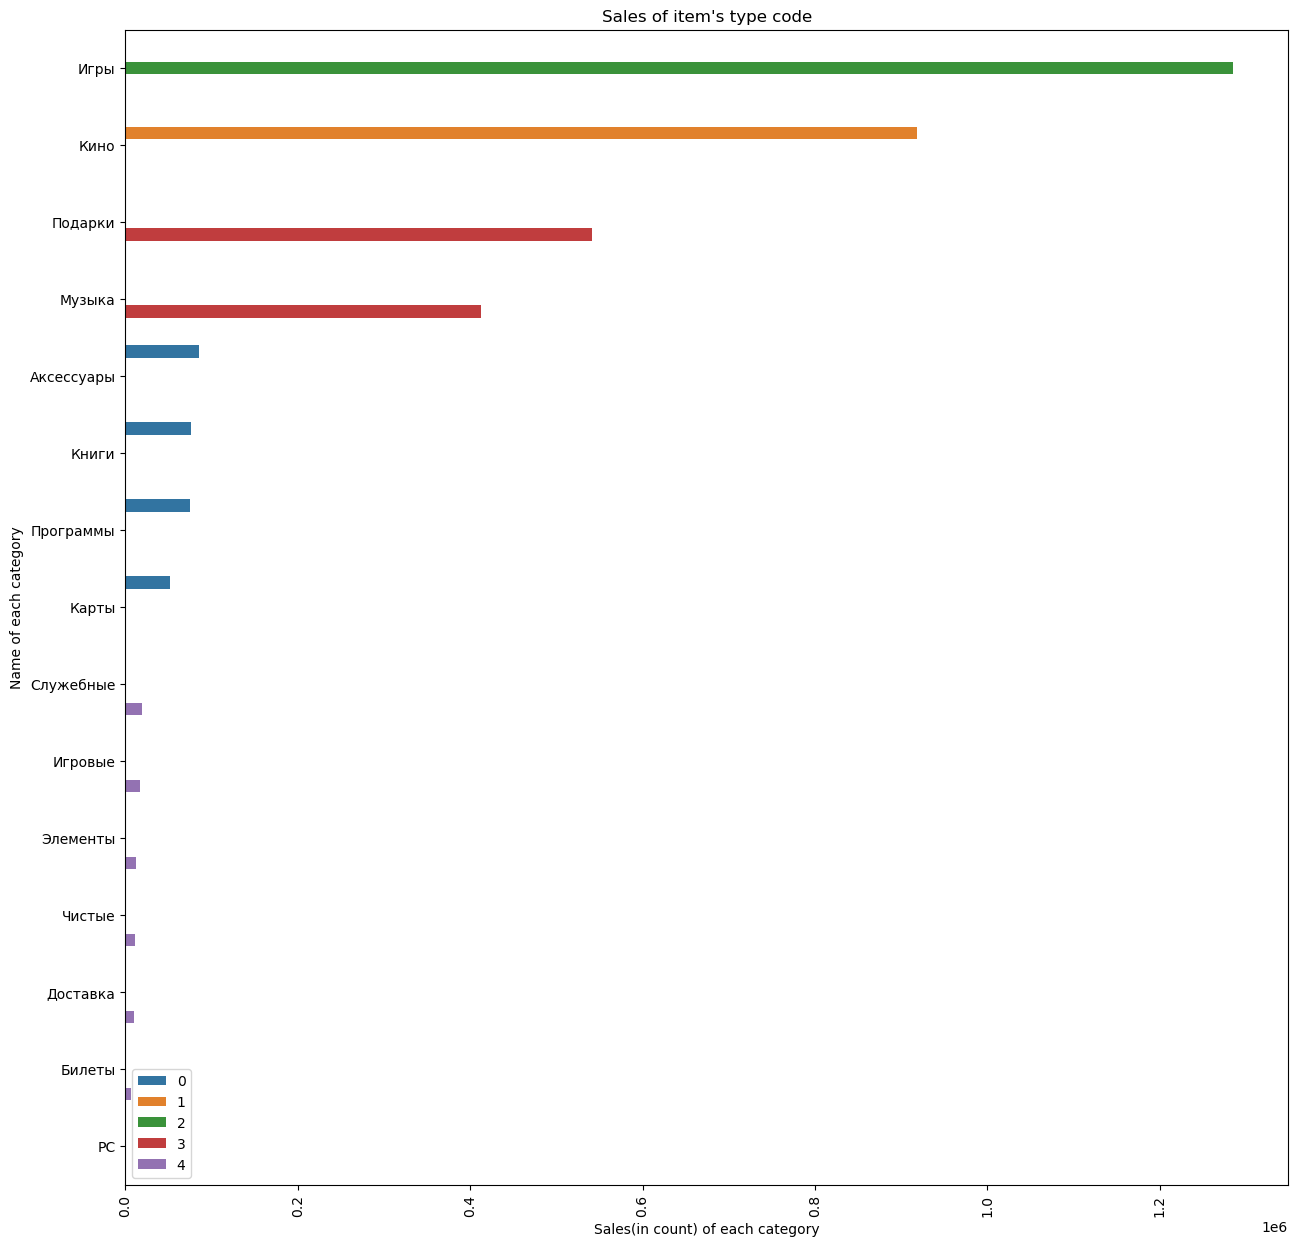

In [10]:
#clusterization
km = KMeans(n_clusters= 5, random_state=42, n_init="auto").fit(type_code_g.to_numpy().reshape(-1, 1))

# visualization
plt.figure(figsize=(15, 15))
ax = sns.barplot(y=type_code_g.index.to_numpy(), x=type_code_g.to_numpy(), hue= km.labels_)
ax.set(ylabel='Name of each category', xlabel='Sales(in count) of each category', title="Sales of item's type code")
ax.tick_params(axis='x', rotation=90)
plt.show()

#saving results of clazterization
labels = mpd.DataFrame(km.labels_, columns=['type_code_cluster_id'])
type_code_clusters = mpd.concat([type_code_g.drop(columns=['category_sales',
                                                 'item_category_name',
                                                 'subtype',
                                                 'type_code'
                                                ]), labels], axis=1)

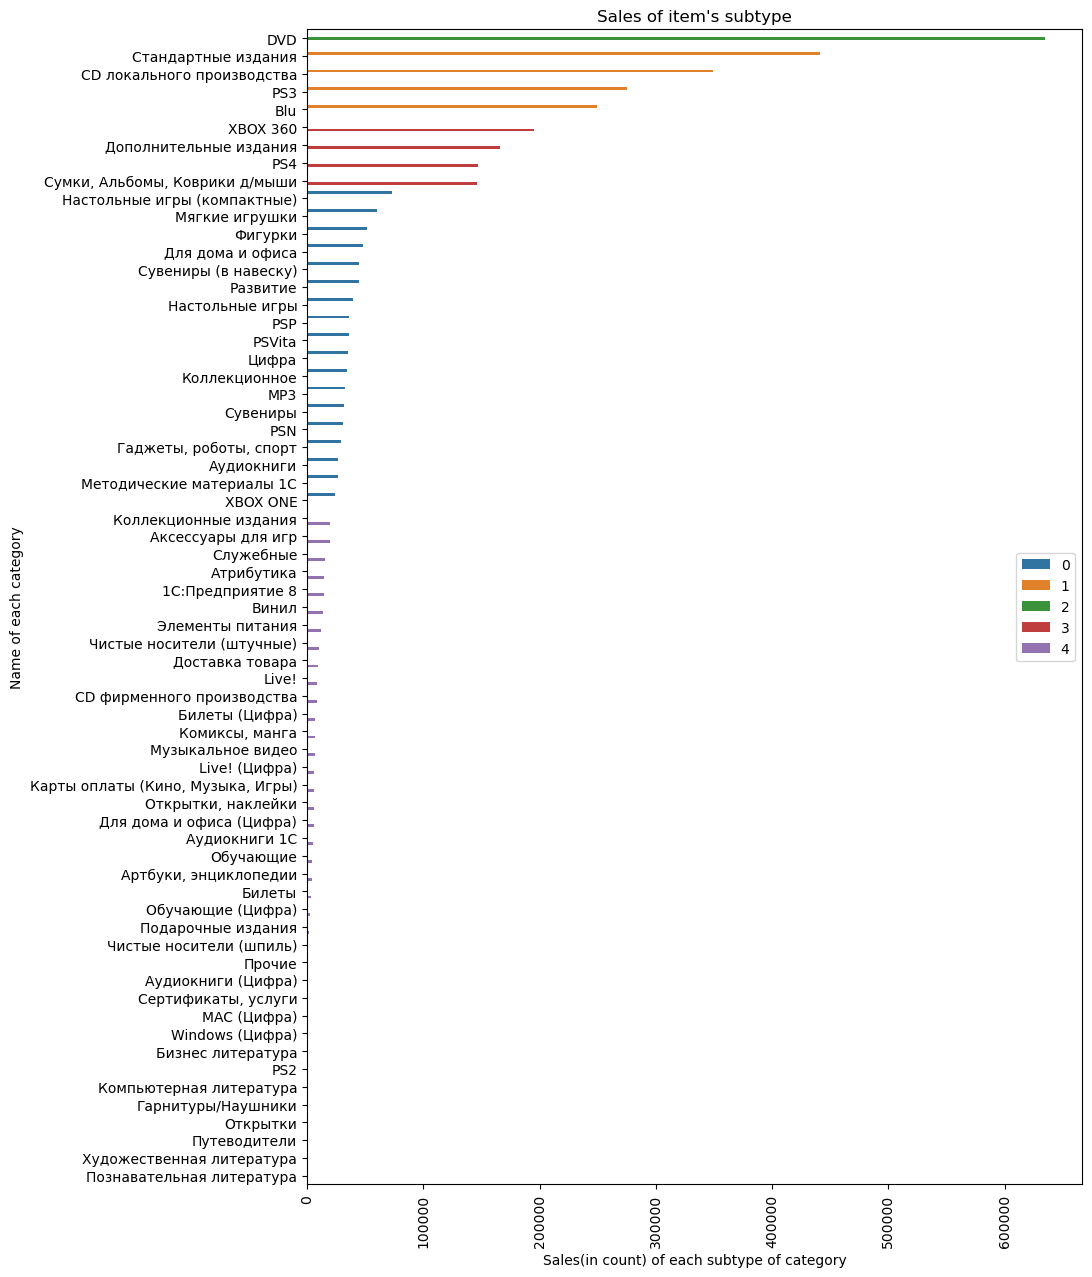

In [11]:
#clusterization
km = KMeans(n_clusters= 5, random_state=42, n_init="auto").fit(subtype_g.to_numpy().reshape(-1, 1))

# visualization
plt.figure(figsize=(10, 15))
ax = sns.barplot(y=subtype_g.index.to_numpy(), x=subtype_g.to_numpy(), hue= km.labels_)
ax.set(ylabel='Name of each category', xlabel='Sales(in count) of each subtype of category', title="Sales of item's subtype")
ax.tick_params(axis='x', rotation=90)
plt.show()

#saving results of clazterization
labels = mpd.DataFrame(km.labels_, columns=['subtype_cluster_id'])
subtype_clusters = mpd.concat([subtype_g.drop(columns=['category_sales',
                                               'item_category_name',
                                               'type_code',
                                               'subtype'
                                              ]), labels], axis=1)

According to these plots, the marketability of subtype and type code of categories can be divided into 5 types.

### Items

In [12]:
# we can try to check what items have high sales
data['items'].head(5)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [13]:
sales_data = data['sales_train'].merge(
        data['items'], how='left', on='item_id'
        ).merge(
                data['item_categories'], how='left', on='item_category_id'
                ).drop(columns=['shop_id', 'year_month', 'item_name'])
sales_data.head(2)

date  date_block_num  item_id  item_price  item_cnt_day  \
0  2013-01-02               0    22154      999.00          1.00   
1  2013-01-03               0     2552      899.00          1.00   

   item_category_id item_category_name  
0                37     Кино - Blu-Ray  
1                58     Музыка - Винил

[Text(0.5, 0, 'Sales of items'),
 Text(0, 0.5, 'sales(in count) of each item'),
 Text(0.5, 1.0, 'Sales of items')]

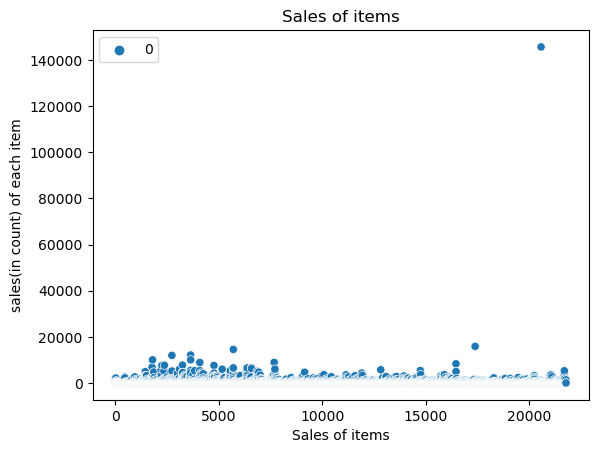

In [14]:
g = mpd.DataFrame(sales_data.groupby(['item_id'])['item_cnt_day'].agg(sum))\
                 .rename(columns={'item_cnt_day':'item_sales'})
ax = sns.scatterplot(g)
ax.set(xlabel='Sales of items', ylabel='sales(in count) of each item', title="Sales of items")

One item has extremely huge sales, need to check what is it

In [15]:
g[g.item_sales > 100000].item_sales

item_id
20949   145695.00
Name: item_sales, dtype: float64

In [16]:
data['items'][data['items'].item_id == 20949]

item_name  item_id  \
20949  Фирменный пакет майка 1С Интерес белый (34*42)...    20949   

       item_category_id  
20949                71

In [17]:
data['test'][data['test'].item_id == 20949].item_id.count()

42

We have to predict sales of this item for 42 shops so we cant remove information about this item

Check items sales without item with id 20949

[Text(0.5, 0, 'Sales of items'),
 Text(0, 0.5, 'sales(in count) of each item'),
 Text(0.5, 1.0, 'Sales of items')]

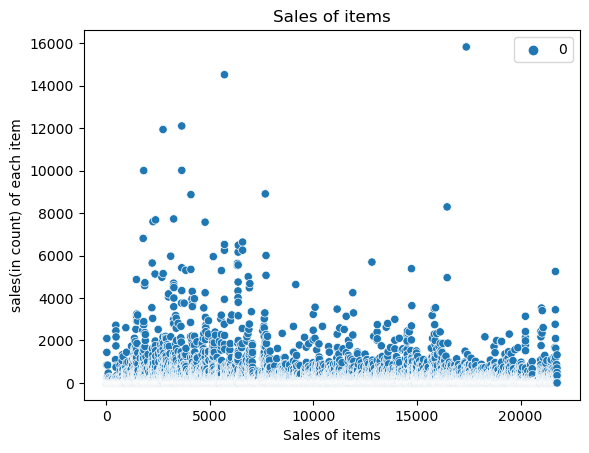

In [18]:
ax = sns.scatterplot(g[(g.index != 20949)])
ax.set(xlabel='Sales of items', ylabel='sales(in count) of each item', title="Sales of items")

Because amount of items is too huge need to try use histplot

[Text(0.5, 1.0, 'Distribution of sales of items')]

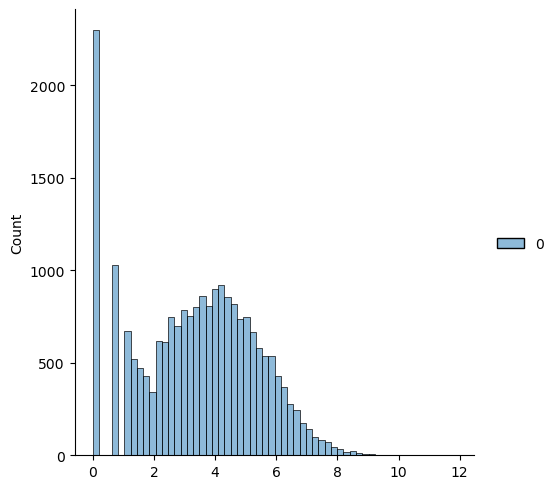

In [19]:
sns.displot(np.log(g))
ax.set(title="Distribution of sales of items")

The distribution of sales of goods in general looks normal, if you do not take into account the records of no sales of goods (i.e., where item_cnt_day is zero)

###### Сhecking of sales (in count) distributuon:

In [20]:
day_sales = data['sales_train']
np.sort(day_sales.item_cnt_day.unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

CPU times: total: 359 ms
Wall time: 540 ms


[Text(0.5, 0, 'Distribution of sales of items per day'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Sales(in count) of items per day')]

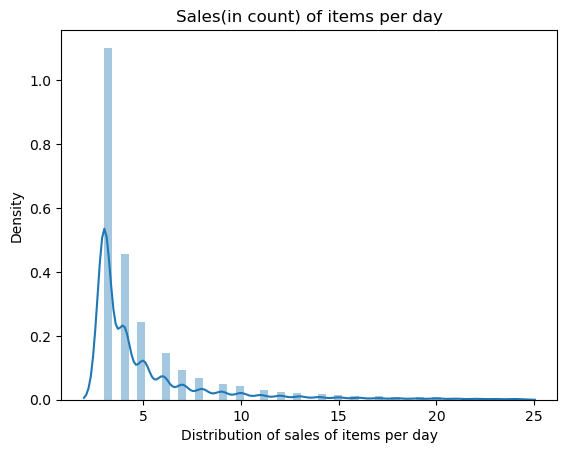

In [21]:
%%time
"""
as 75% of item_cnt_months is 2 so in the next parts of EDA we should cut left tail to look at right tail better
"""
ax = sns.distplot(day_sales[day_sales.item_cnt_day > 2].item_cnt_day)
ax.set(xlabel='Distribution of sales of items per day', ylabel="Density", title="Sales(in count) of items per day")

Amount of sales per day presents by exponential distribution with very long tail. Check count of days by months when item_cnt_day is more than 20

[Text(0.5, 0, 'Lineplot of sales of items per month'),
 Text(0, 0.5, 'Count of items'),
 Text(0.5, 1.0, 'Number of days by month with sales over 20')]

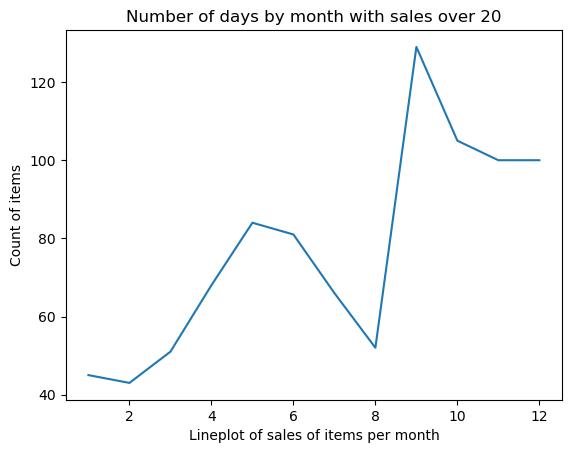

In [22]:
sales_data['month'] = mpd.DatetimeIndex(sales_data['date']).month
days_with_high_sales_by_month = sales_data[sales_data.item_cnt_day > 20].groupby('month')['item_cnt_day'].count()
df = mpd.DataFrame({'month': days_with_high_sales_by_month.index, 'count': days_with_high_sales_by_month.values})
ax = sns.lineplot(data=df, x='month', y='count')
ax.set(xlabel='Lineplot of sales of items per month', ylabel="Count of items", title="Number of days by month with sales over 20")

Days with a lot of sales fall on the 9th, 10th, 11th, 12th month.

Сhecking of sales (in price) distributuon

In [23]:
sales_data.item_price.describe()

count   2924482.00
mean        822.94
std        1191.32
min           0.07
25%         249.00
50%         399.00
75%         999.00
max       17791.68
Name: item_price, dtype: float64

CPU times: total: 26.7 s
Wall time: 31 s


Text(0.5, 1.0, 'Logarithmic distribution of item sales (in price)')

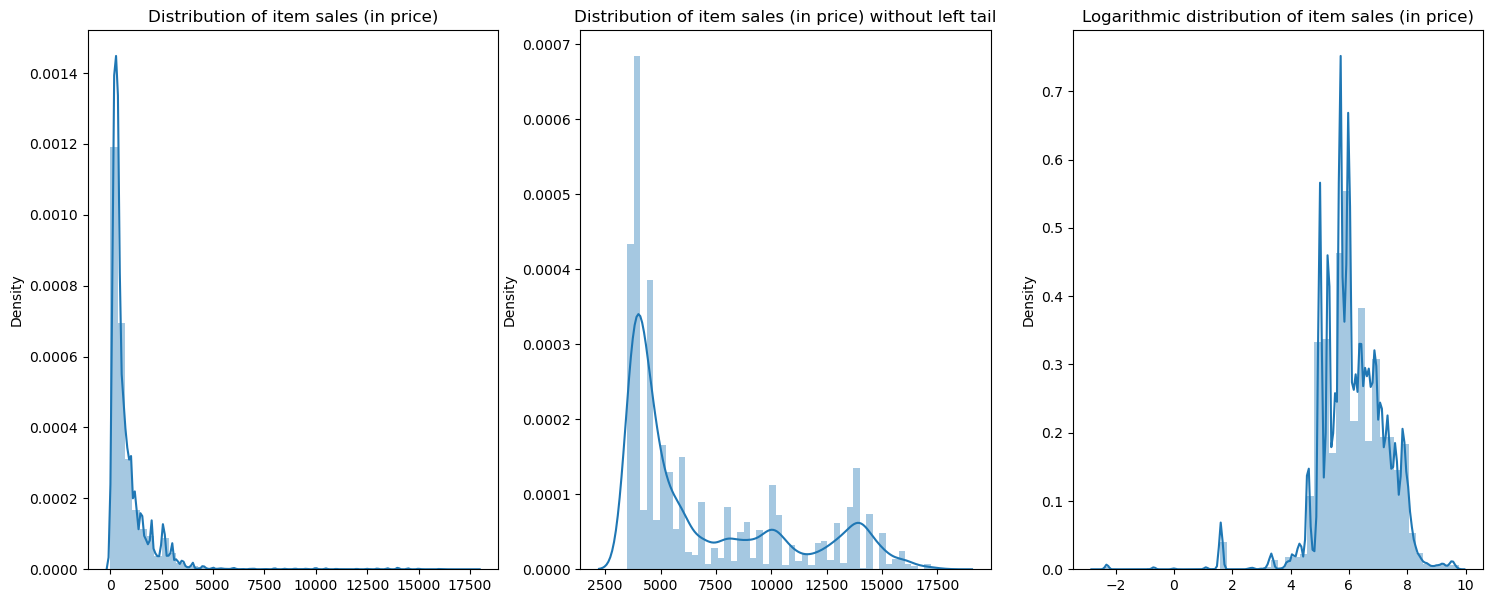

In [24]:
%%time
fig, axes = plt.subplots(1, 3, figsize=(18, 7))
sns.distplot(ax=axes[0], x=sales_data.item_price)
sns.distplot(ax=axes[1], x=sales_data[sales_data.item_price > 3500].item_price)
sns.distplot(ax=axes[2], x=np.log(sales_data[sales_data.item_price > 0].item_price))
axes[0].set_title("Distribution of item sales (in price)")
axes[1].set_title("Distribution of item sales (in price) without left tail")
axes[2].set_title("Logarithmic distribution of item sales (in price)")

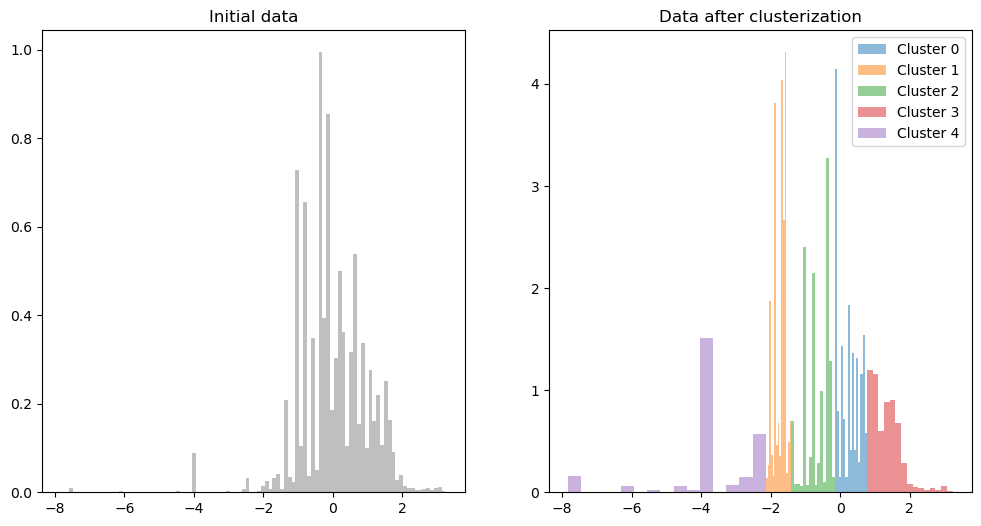

In [25]:
# data normalization
scaler = StandardScaler()
norm_prices = scaler.fit_transform(mpd.DataFrame(np.log(sales_data.item_price)))
n_components = 5

gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(norm_prices)
items_value = gmm.predict(norm_prices)

# show inittial data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(norm_prices, bins=100, density=True, alpha=0.5, color='gray')
plt.title('Initial data')

# show clusters
plt.subplot(1, 2, 2)
for cluster_label in range(n_components):
    cluster_data = norm_prices[items_value == cluster_label]
    plt.hist(cluster_data, bins=15, density=True, alpha=0.5, label=f'Cluster {cluster_label}')
plt.title('Data after clusterization')
plt.legend()

plt.show()

#saving results of clazterization
cluster_results = mpd.DataFrame(items_value, columns=['item_price_cluster_id'])
item_price_clusters = mpd.concat([sales_data.\
                                  drop(columns=['date',
                                                'date_block_num',
                                                'item_cnt_day',
                                                'item_category_id',
                                                'item_category_name',
                                                'month',
                                                'item_price'
                                               ]), cluster_results], axis=1)

Сlustered items by price

Check for distribution of price of items

CPU times: total: 234 ms
Wall time: 1.03 s


[Text(0.5, 0, 'Distribution of price sales per day'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'sales(in price) of each item')]

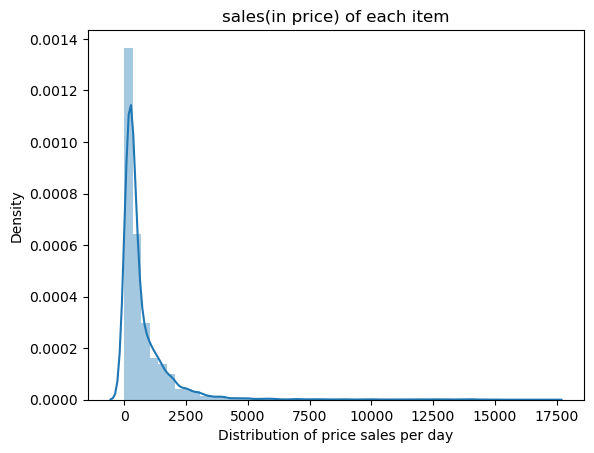

In [26]:
%%time
items_price = sales_data[sales_data.item_cnt_day == 1].drop_duplicates('item_id')
ax = sns.distplot(items_price.item_price)
ax.set(xlabel='Distribution of price sales per day', ylabel="Density", title="sales(in price) of each item")

A lot of items are cheap, need to check how price is affects sales

In [27]:
items_price_data = sales_data.merge(mpd.DataFrame(items_price[['item_price', 'item_id']])\
                                    .rename(columns={'item_price':'price_of_one_item'}), on='item_id', how='left')\
                                    .drop_duplicates('item_id').dropna()

In [28]:
data['sales_train'].item_id.nunique() - items_price_data.shape[0]

87

87 items have never sold in one copy(we can get price of this items by division)

In [29]:
items_sales_info = sales_data.groupby('item_id')['item_cnt_day'].count().reset_index()
corr_price_sales = items_sales_info.merge(items_price_data[['price_of_one_item', 'item_id']], on='item_id', how='inner')

In [30]:
corr_price_sales=corr_price_sales.groupby('item_id')[['item_cnt_day', 'price_of_one_item']].agg(sum).sort_values(by='item_cnt_day')
corr_price_sales.tail()

item_cnt_day  price_of_one_item
item_id                                 
4181             6853             999.00
2808             7354             999.00
17717            9067             999.00
5822             9408             999.00
20949           30304               5.00

In [31]:
corr_price_sales.corr()

item_cnt_day  price_of_one_item
item_cnt_day               1.00               0.03
price_of_one_item          0.03               1.00

No correlation between price of item and sales of this item

###### Checking for corr between time and sales:

In [32]:
month_sales = mpd.DataFrame(sales_data.groupby(["date_block_num"])['item_cnt_day'].agg(sum))\
    .rename(columns={"item_cnt_day":"item_cnt_month"}).reset_index()
month_sales.describe()

date_block_num  item_cnt_month
count           34.00           34.00
mean            16.50       103570.94
std              9.96        27838.83
min              0.00        62806.00
25%              8.25        84976.25
50%             16.50       104941.50
75%             24.75       121206.50
max             33.00       176274.00

[Text(0.5, 0, 'Month number'),
 Text(0, 0.5, 'Amount'),
 Text(0.5, 1.0, 'Sales of all items per month')]

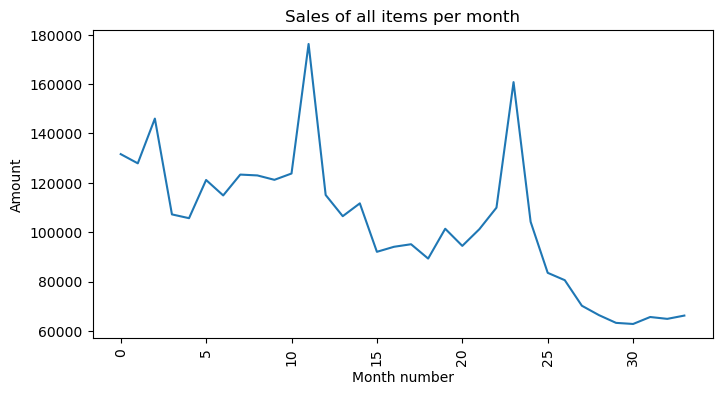

In [33]:
fig, ax = plt.subplots(figsize=(8,4))
g_by_months = sns.lineplot(y= month_sales.item_cnt_month, x = month_sales.date_block_num)
cnt = g_by_months.set_xticklabels(g_by_months.get_xticklabels(), rotation=90)
g_by_months.set(xlabel='Month number', ylabel="Amount", title="Sales of all items per month")

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


(<Figure size 1250x510 with 4 Axes>,
 array([<Axes: ylabel='2013'>, <Axes: ylabel='2014'>,
        <Axes: ylabel='2015'>], dtype=object))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


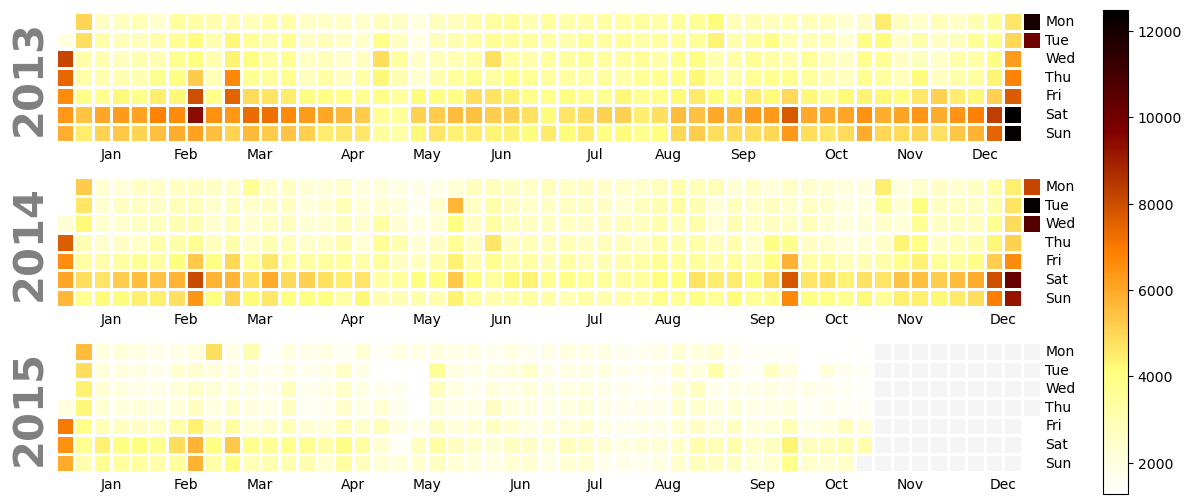

In [34]:

df = pd.DataFrame()
df['date'] = pd.to_datetime(data['sales_train']['date'].to_numpy(), yearfirst=True)
df['price'] = data['sales_train']['item_cnt_day'].to_numpy()
df= df.set_index('date')

calplot.calplot(df['price'], edgecolor=None, cmap='afmhot_r')

###### It can be seen that the sales increase at the end of the year, which most likely indicates the presence of seasonality. There is also a noticeable decrease in sales over time.

In [35]:
%%time
sales_data.date = mpd.to_datetime(sales_data.date)
sales_data['week_number'] = (sales_data.date - min(sales_data.date)).dt.days // 7
week_sales = mpd.DataFrame(sales_data.groupby(["week_number"])['item_cnt_day'].agg(sum))\
    .rename(columns={"item_cnt_day":"item_cnt_week"}).reset_index()
week_sales.describe()

CPU times: total: 4.08 s
Wall time: 8.26 s


week_number  item_cnt_week
count       148.00         148.00
mean         73.50       23793.32
std          42.87        7670.50
min           0.00        9924.00
25%          36.75       18818.25
50%          73.50       23662.00
75%         110.25       27255.50
max         147.00       62604.00

[Text(0.5, 0, 'Week number'),
 Text(0, 0.5, 'Amount'),
 Text(0.5, 1.0, 'Sales of all items per week')]

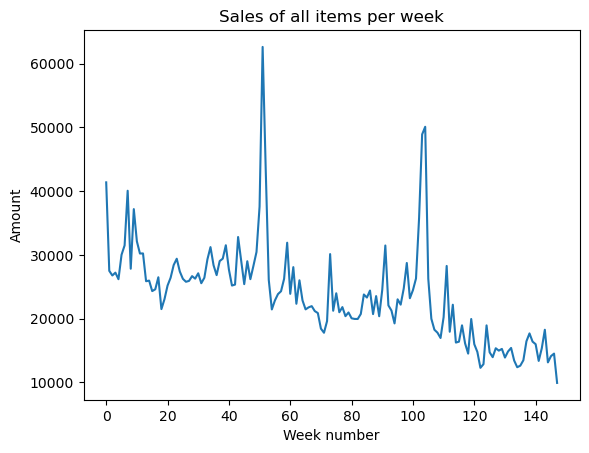

In [36]:
ax = sns.lineplot(x=week_sales.week_number.to_list(), y=week_sales.item_cnt_week.to_list())
ax.set(xlabel='Week number', ylabel="Amount", title="Sales of all items per week")

In [37]:
sales_data.head()

date  date_block_num  item_id  item_price  item_cnt_day  \
0 2013-01-02               0    22154      999.00          1.00   
1 2013-01-03               0     2552      899.00          1.00   
2 2013-01-05               0     2552      899.00          0.00   
3 2013-01-06               0     2554     1709.05          1.00   
4 2013-01-15               0     2555     1099.00          1.00   

   item_category_id                   item_category_name  month  week_number  
0                37                       Кино - Blu-Ray      1            0  
1                58                       Музыка - Винил      1            0  
2                58                       Музыка - Винил      1            0  
3                58                       Музыка - Винил      1            0  
4                56  Музыка - CD фирменного производства      1            2

###### ACF & PACF of item count sales per month 

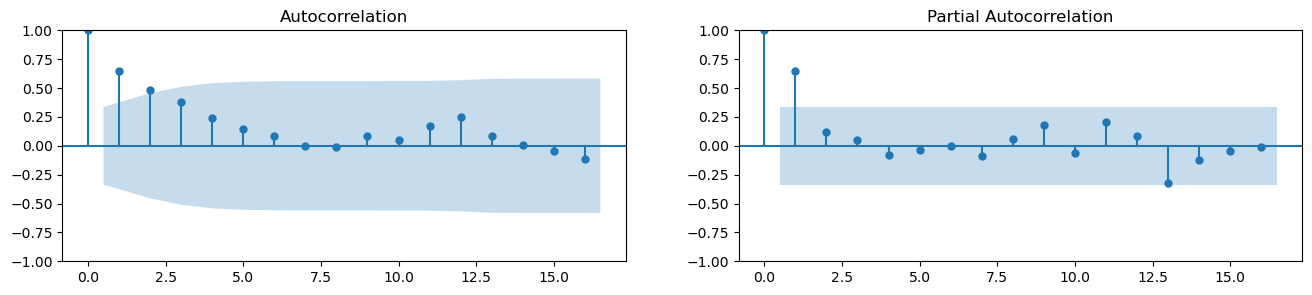

In [38]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
axes[0] = plot_acf(month_sales['item_cnt_month'], lags=None, ax=axes[0])
axes[1] = plot_pacf(month_sales['item_cnt_month'], lags=None, ax=axes[1])

There is a seasonal dependence. Maybe need to try a lags of [1, 2, 3, 12] for months.

###### ACF & PACF of average item count sales per month 

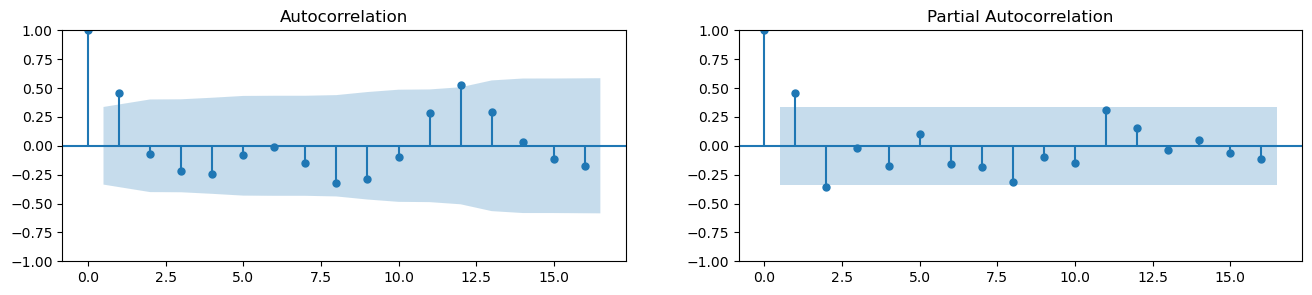

In [39]:
group = data['sales_train'].groupby(["date_block_num"] ).agg({"item_cnt_day" : "mean"})
group.columns = ["avg_by_month_item_cnt"]
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
axes[0] = plot_acf(group, lags=None, ax=axes[0])
axes[1] = plot_pacf(group, lags=None, ax=axes[1])

###### ACF & PACF of average item sales per month of each item

CPU times: total: 62.5 ms
Wall time: 557 ms


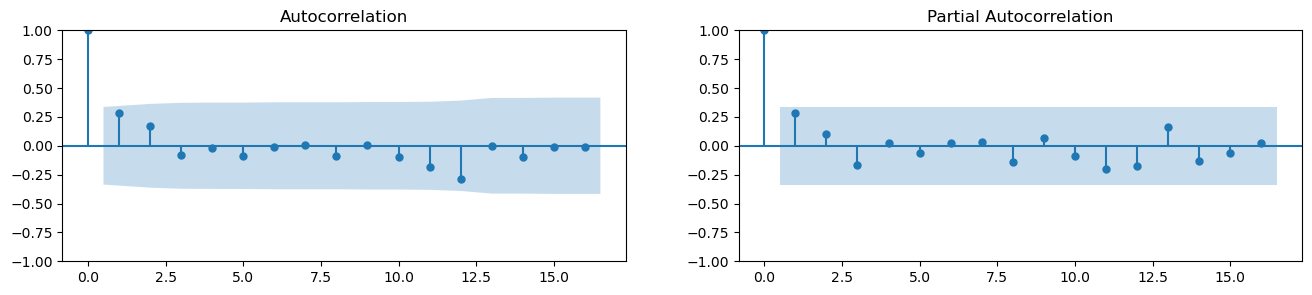

In [40]:
%%time
# lag of average item sales per month of each item_id

group = data['sales_train'].groupby(['date_block_num', 'item_id']).agg({'item_cnt_day': 'mean'})
group.columns = ['avg_by_month_item_id_item_cnt']
group = group.reset_index()
group = group[group.item_id == 10391].avg_by_month_item_id_item_cnt
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
axes[0] = plot_acf(group, lags=None, ax=axes[0])
axes[1] = plot_pacf(group, lags=None, ax=axes[1])

###### ACF & PACF of average item sales per month of each shop

CPU times: total: 46.9 ms
Wall time: 329 ms


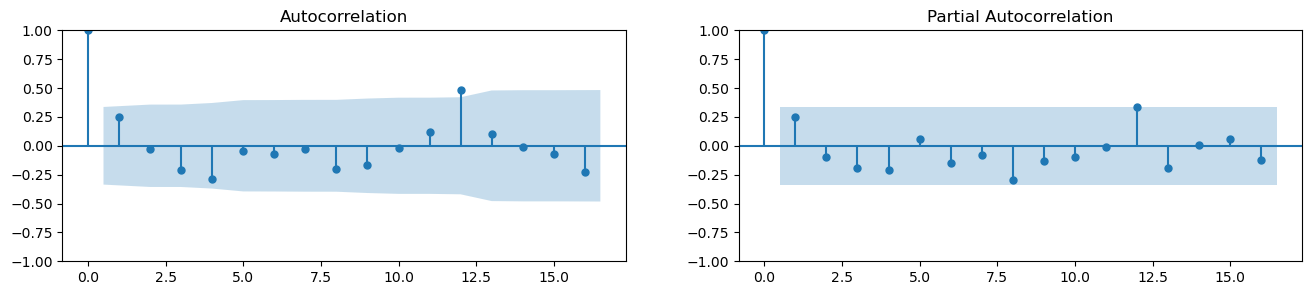

In [41]:
%%time
# lag of average item sales per month of each shop

group = data['sales_train'].groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day': 'mean'})
group.columns = ['avg_by_month_shop_item_cnt']
group = group.reset_index()
group = group[group.shop_id == 15].avg_by_month_shop_item_cnt
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
axes[0] = plot_acf(group, lags=None, ax=axes[0])
axes[1] = plot_pacf(group, lags=None, ax=axes[1])

###### ACF & PACF of average item sales per month of each city

CPU times: total: 125 ms
Wall time: 1.22 s


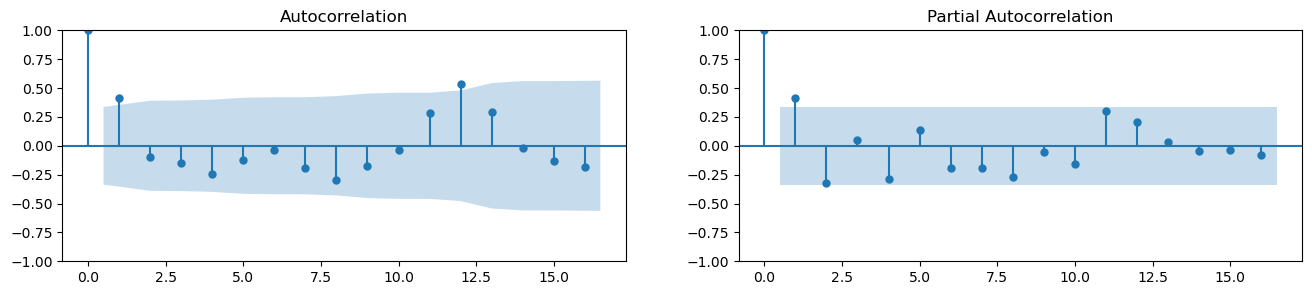

In [42]:
%%time
# lag of average item sales per month of each city

group = data['sales_train'].merge(data['shops'], on='shop_id', how='inner')\
                .groupby(['date_block_num', 'city']).agg({'item_cnt_day': 'mean'})
group.columns = ['avg_by_month_city_item_cnt']
group = group.reset_index()
group = group[group.city == "Москва"].avg_by_month_city_item_cnt
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
axes[0] = plot_acf(group, lags=None, ax=axes[0])
axes[1] = plot_pacf(group, lags=None, ax=axes[1])

###### ACF & PACF of average item sales per month of each category

CPU times: total: 266 ms
Wall time: 1.81 s


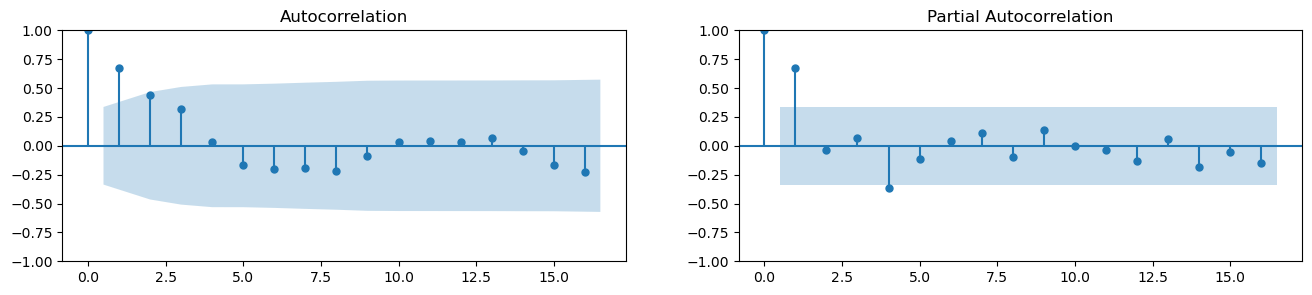

In [43]:
%%time
# lag of average item sales per month of each category

group = data['sales_train'].merge(data['items'], on='item_id', how='inner')\
                    .merge(data['item_categories'], on='item_category_id', how='inner')\
                    .groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_day': 'mean'})
group.columns = ['avg_by_month_cat_item_cnt']
group = group.reset_index()
group = group[group.item_category_id == 35].avg_by_month_cat_item_cnt
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
axes[0] = plot_acf(group, lags=None, ax=axes[0])
axes[1] = plot_pacf(group, lags=None, ax=axes[1])

###### Check how month with same names correlated by sales

In [44]:
sales_data['year'] = sales_data.date.dt.year

In [45]:
g = sales_data.groupby(['week_number', 'year']).agg({'item_id': 'count'})\
    .reset_index().rename(columns={'item_id':'item_cnt_week'})

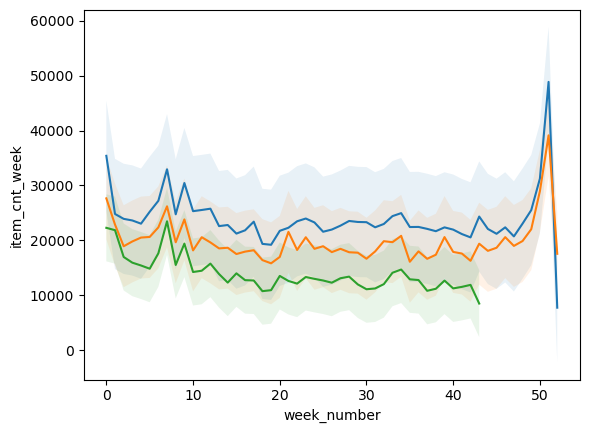

In [46]:
fig, ax = plt.subplots()
shift = 0
for year in g.year.unique():
    year_sample = g[g.year == year]
    ax = sns.lineplot(x=year_sample.week_number - shift*52, y=year_sample.item_cnt_week)
    temp_std = year_sample.item_cnt_week.std()
    ax = plt.fill_between(year_sample.week_number - shift*52,
                     year_sample.item_cnt_week - 1.96 * temp_std,
                     year_sample.item_cnt_week + 1.96 * temp_std,
                     alpha=0.1)
    shift += 1
#ax.set(xlabel='Week number', ylabel="Amount of sales", title="Sales of all items per year by week")

 Sales for every year looks similary for the same month. As mentioned earlier there is a decreasing trend in the number of sales (in 2015 sales are less than in previous years). No full information about green year (2015).

###### Check for shops with largest/smallest amount of sales

In [47]:
shop_sales_data = data['sales_train'].merge(
            data['items'], how='left', on='item_id'
        ).merge(
            data['item_categories'], how='left', on='item_category_id'
        ).merge(
           data['shops'], on='shop_id', how='left'
        )
shop_sales_data.head(2)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  2013-01-02               0       59    22154      999.00          1.00   
1  2013-01-03               0       25     2552      899.00          1.00   

  year_month                                 item_name  item_category_id  \
0    2013-01                         ЯВЛЕНИЕ 2012 (BD)                37   
1    2013-01  DEEP PURPLE  The House Of Blue Light  LP                58   

  item_category_name               shop_name       city  
0     Кино - Blu-Ray  Ярославль ТЦ "Альтаир"  Ярославль  
1     Музыка - Винил     Москва ТРК "Атриум"     Москва

In [48]:
%%time
shop_sales_data.loc[shop_sales_data.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shop_sales_data["shop_city"] = shop_sales_data.shop_name.str.split(" ").map(lambda x: x[0])
shop_sales_data["shop_category"] = shop_sales_data.shop_name.str.split(" ").map(lambda x: x[1])
shop_sales_data.loc[shop_sales_data.shop_city == "!Якутск", "shop_city"] = "Якутск"
shop_sales_data.head(2)

CPU times: total: 234 ms
Wall time: 200 ms


date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  2013-01-02               0       59    22154      999.00          1.00   
1  2013-01-03               0       25     2552      899.00          1.00   

  year_month                                 item_name  item_category_id  \
0    2013-01                         ЯВЛЕНИЕ 2012 (BD)                37   
1    2013-01  DEEP PURPLE  The House Of Blue Light  LP                58   

  item_category_name               shop_name       city  shop_city  \
0     Кино - Blu-Ray  Ярославль ТЦ "Альтаир"  Ярославль  Ярославль   
1     Музыка - Винил     Москва ТРК "Атриум"     Москва     Москва   

  shop_category  
0            ТЦ  
1           ТРК

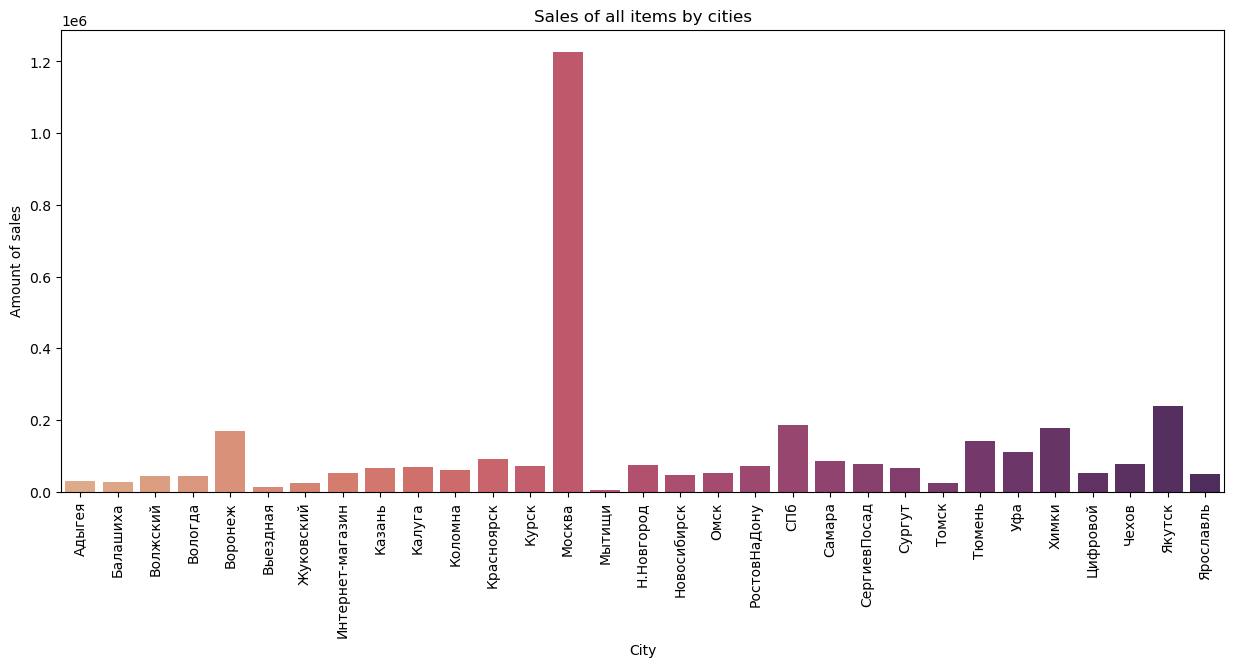

In [49]:
g = shop_sales_data.groupby('shop_city')['item_cnt_day'].agg(sum).reset_index()
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=g.shop_city.to_numpy(), y=g.item_cnt_day.to_numpy(), palette="flare")
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='City', ylabel="Amount of sales", title="Sales of all items by cities")
plt.show()

Moscow has extremely huge sales. Need to compare the number of stores

CPU times: total: 891 ms
Wall time: 10.3 s


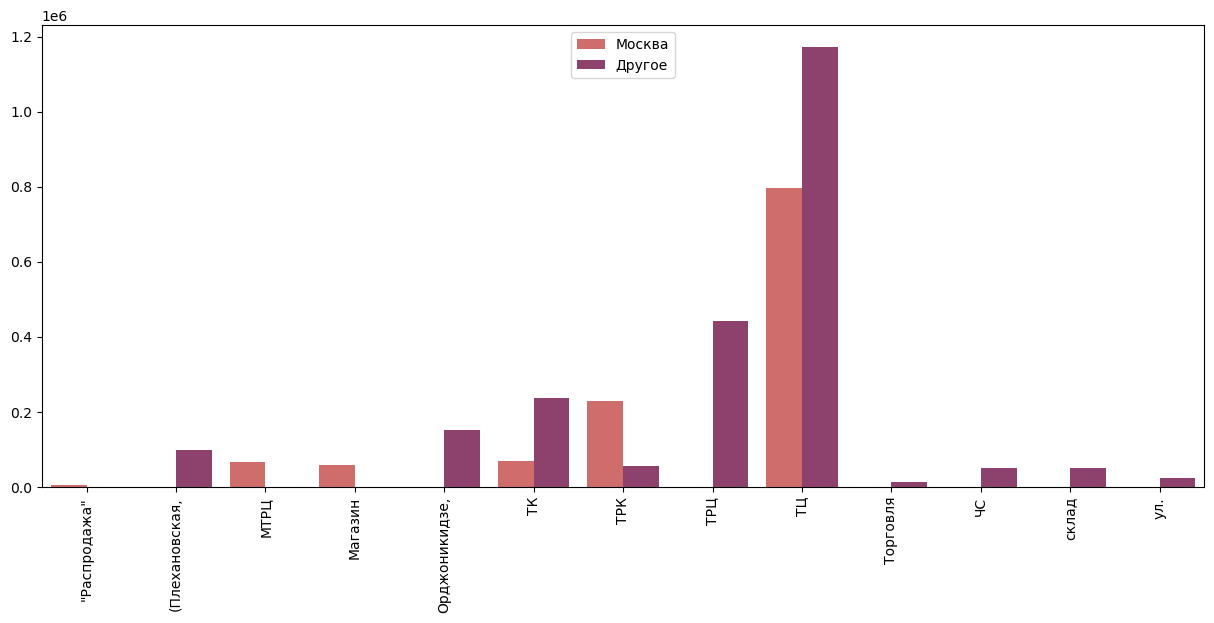

In [50]:
%%time
plt.figure(figsize=(15, 6))
shop_sales_data['is_Moscow'] = shop_sales_data['shop_city'].where(shop_sales_data.shop_city == 'Москва', other='Другое')
g = shop_sales_data.groupby(['shop_category', 'is_Moscow'])['item_cnt_day'].agg(sum).reset_index()
ax = sns.barplot(x=g.shop_category.to_numpy(), y=g.item_cnt_day.to_numpy(), palette="flare", hue=g.is_Moscow.to_numpy())
ax.tick_params(axis='x', rotation=90)

There are big part of shops located in Moscow, but some no, so it's hard to cluster it manually. Stores need to be clustered using algorithm.

###### Shops clasterization (try to cluster shops by sales)

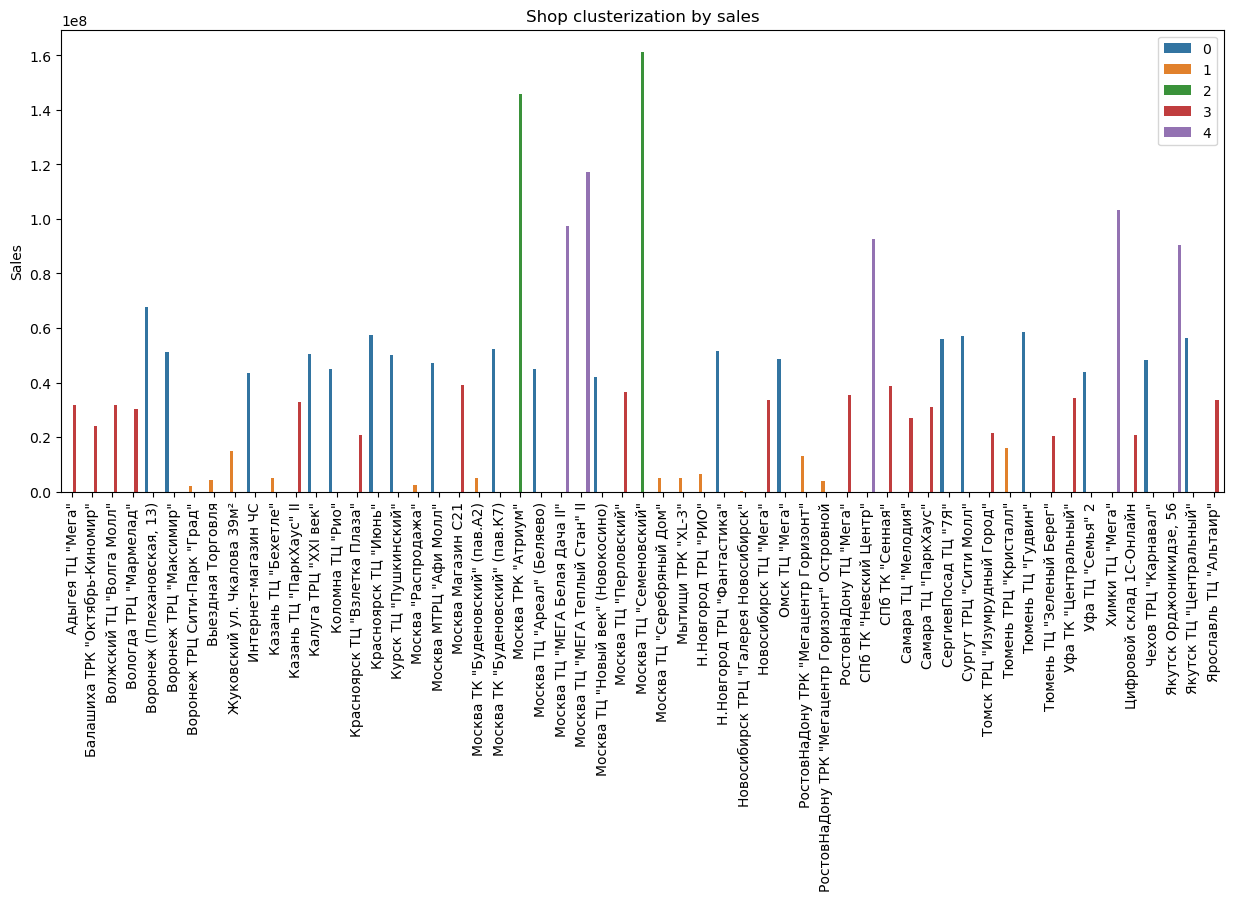

In [51]:
# group shops by sales
to_clust_shops_name = shop_sales_data.groupby(['shop_name'])['item_price'].agg(sum).reset_index()
to_clust_shops_id = shop_sales_data.groupby(['shop_id'])['item_price'].agg(sum).reset_index()

# clustering
km = KMeans(n_clusters= 5, random_state=42, n_init="auto").fit(to_clust_shops_name.item_price.to_numpy().reshape(-1, 1))
labels = mpd.DataFrame(km.labels_, columns=['cluster_id'])
clusters_info = mpd.concat([to_clust_shops_name, labels], axis=1)
clusters_info = clusters_info.rename(columns={"item_price":"sales_amount"})

#visualization
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=clusters_info["shop_name"].to_numpy(), y=clusters_info["sales_amount"].to_numpy(),
            hue=clusters_info["cluster_id"].to_numpy())
ax.set_title("Shop clusterization by sales")
ax.set_ylabel("Sales")
cnt = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#saving results of clazterization
cluster_results = labels
shop_clusters = mpd.concat([to_clust_shops_id.\
                                  drop(columns=[
                                                'item_price'
                                               ]), cluster_results], axis=1)

Check is there enough information about each shop

[Text(0.5, 0, 'Amount of store records'),
 Text(0, 0.5, 'Amount of shops'),
 Text(0.5, 1.0, 'Histogram of store records')]

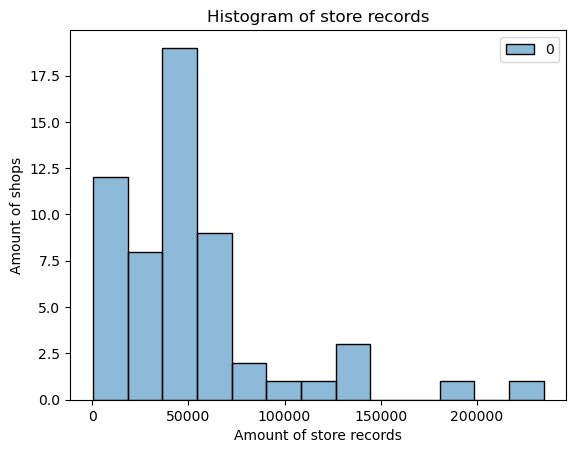

In [52]:
g = shop_sales_data.groupby('shop_id').agg({'date':'count'})
ax = sns.histplot(g)
ax.set(xlabel='Amount of store records', ylabel="Amount of shops", title="Histogram of store records")

Check amount of records for each shop

In [53]:
# add for all shops amount of records
shop_records = shop_sales_data.groupby('shop_id').agg({'date':'count'}).rename(columns={"date":"records_amount"}).reset_index()

In [54]:
shop_records = shop_records.merge(data['shops'], on='shop_id', how='right')

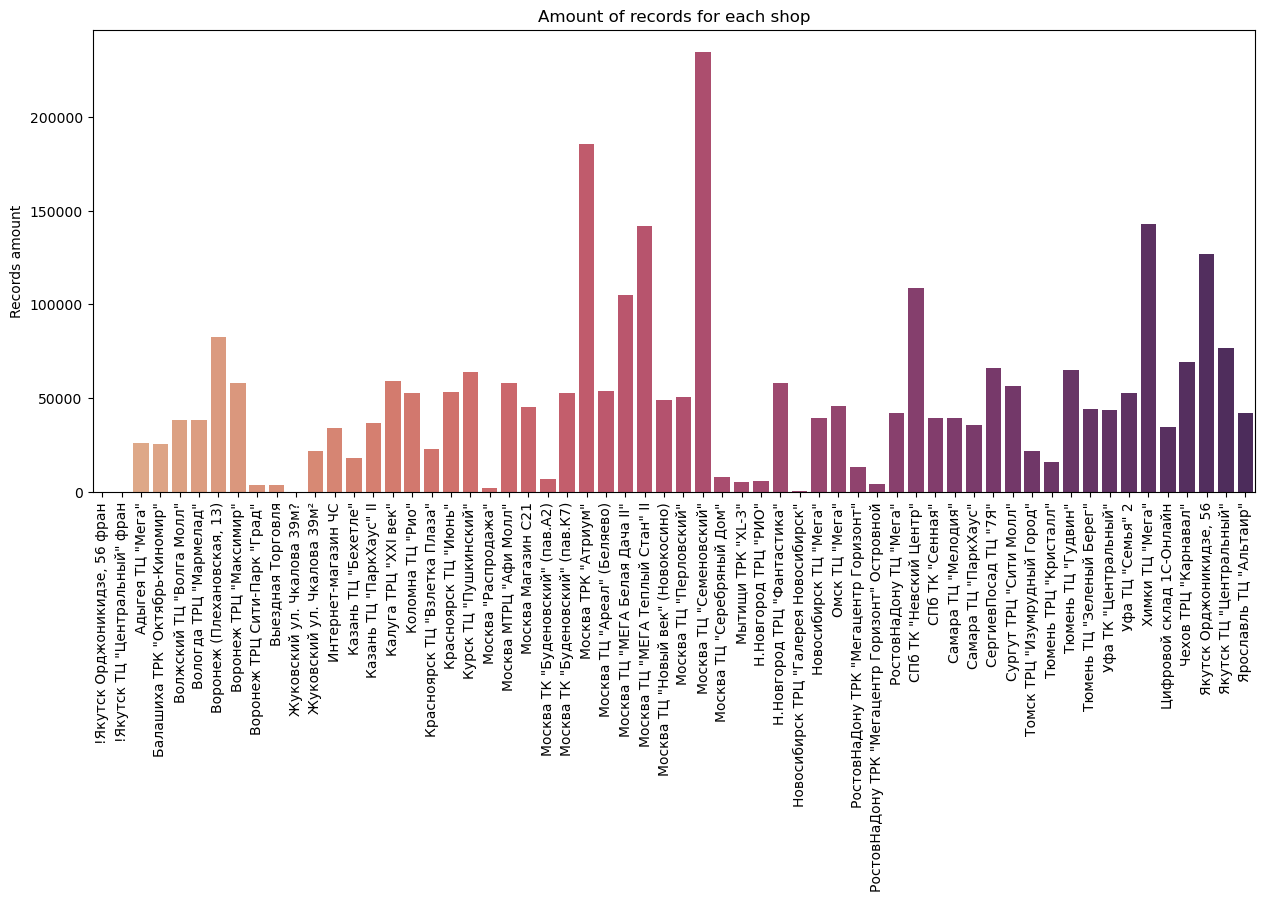

In [55]:
#visualization
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=shop_records["shop_name"].to_numpy(), y=shop_records["records_amount"].to_numpy(), palette='flare')
ax.set_title("Amount of records for each shop")
ax.set_ylabel("Records amount")
cnt = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

A lot of shops have really poor information of sales (maybe some shops closed in this 3 year interval or they are not popular at all). Maybe need to make a features like first sale of item and last sale of item.

Check how items/categories of items distributed by cities

Dynamic plot

In [56]:
import plotly.express as px

In [57]:
df = data['sales_train'].merge(
        data['items'], how='left', on='item_id'
        ).merge(
                data['item_categories'], how='left', on='item_category_id'
                ).merge(
                        data['shops'], how='left', on='shop_id'
                        ).drop(columns=['year_month', 'item_name'])
df["shop_city"] = df.shop_name.str.split(" ").map(lambda x: x[0])
df["shop_category"] = df.shop_name.str.split(" ").map(lambda x: x[1])
df.loc[df.shop_city == "!Якутск", "shop_city"] = "Якутск"
df.loc[df.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
df = df.groupby(['shop_city', 'item_category_id']).agg({'item_price':'sum', 'item_cnt_day':'sum'}).reset_index().sort_values(by=['item_price']).\
    merge(data['item_categories'], on='item_category_id', how='left')
df["type_code"] = df.item_category_name.apply(lambda x: x.split(" ")[0]).astype(str)
df["split"] = df.item_category_name.apply(lambda x: x.split("-"))
df["subtype"] = df.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df = df.drop(columns=['split'])
df1 = df.groupby(['shop_city', 'item_category_name']).agg({'item_price':'sum', 'item_cnt_day':'sum'}).reset_index().sort_values(by='item_cnt_day')

In [58]:
fig = px.bar(
    x=df1["item_cnt_day"].to_numpy(),
    y=df1["item_category_name"].to_numpy(),
    animation_frame=df1["shop_city"].to_numpy(),
    range_x=[100, 100000],
    range_y=[25,90]
)

fig.update_layout(
    width=800,
    height=600
)

fig.show()

Tile plot

In [59]:
df1.head()

shop_city                 item_category_name  item_price  \
1384         Томск                  Кино - Blu-Ray 4K      299.00   
1276  СергиевПосад  Книги - Художественная литература      199.00   
935    Новосибирск                     Билеты (Цифра)     1500.00   
905     Н.Новгород    Книги - Компьютерная литература      249.00   
1354        Сургут              Программы - Обучающие      399.00   

      item_cnt_day  
1384          1.00  
1276          1.00  
935           1.00  
905           1.00  
1354          1.00

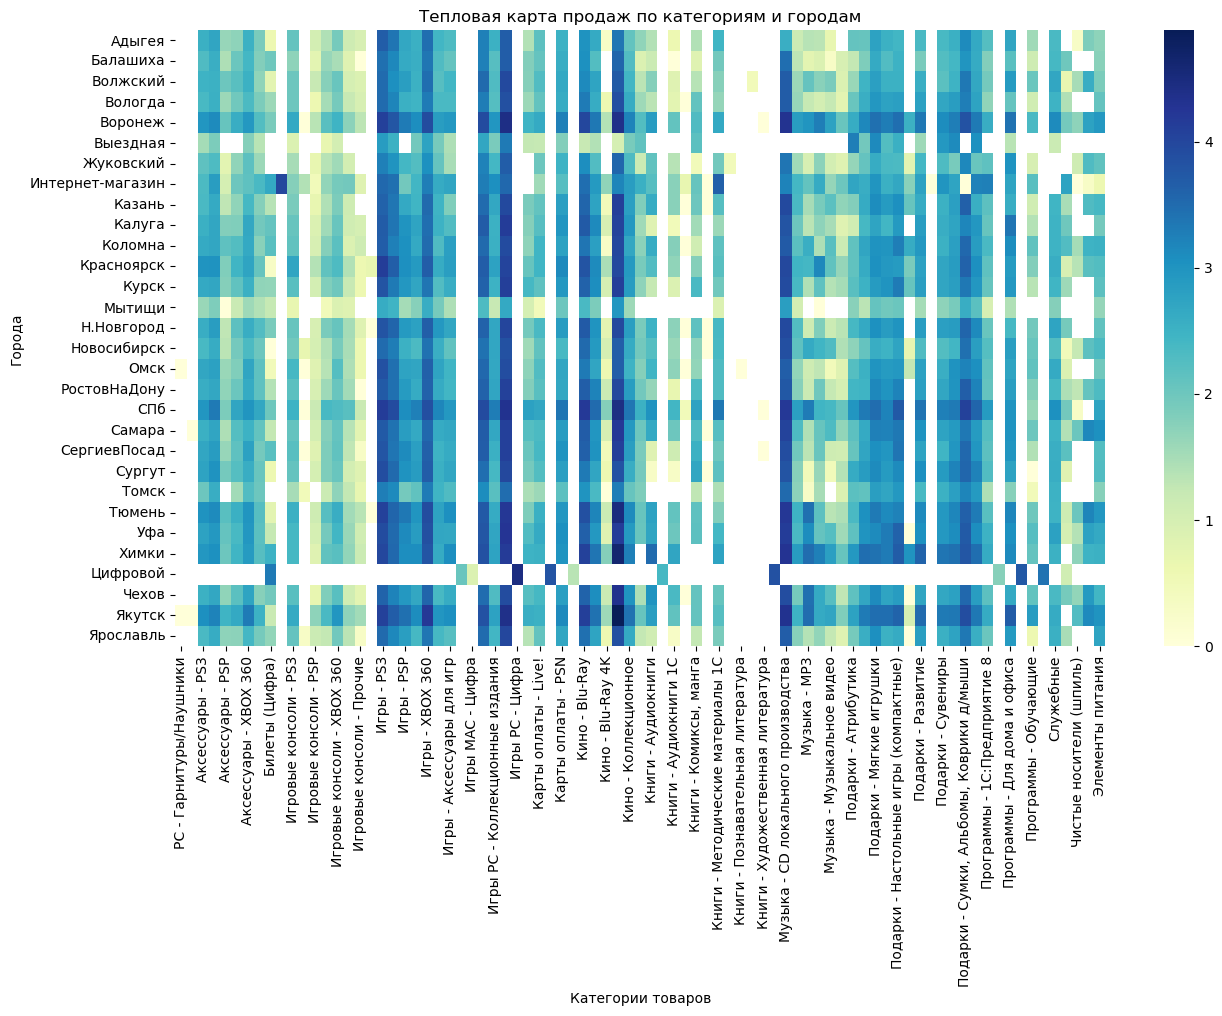

In [60]:
df = {
    'shop_city': df1.shop_city.to_numpy(),
    'item_cat': df1.item_category_name.to_numpy(),
    'item_cnt_day': df1.item_cnt_day.to_numpy()
}
 

df = pd.DataFrame(df)
df = df[df.shop_city != "Москва"]

pivot_table = df.pivot_table(values='item_cnt_day', index='shop_city', columns='item_cat')

plt.figure(figsize=(15, 8))
sns.heatmap(data=np.log10(pivot_table), annot=False, cmap='YlGnBu')
plt.title('Тепловая карта продаж по категориям и городам')
plt.xlabel('Категории товаров')
plt.ylabel('Города')
plt.show()



1. Most sales in many categories are concentrated in Moscow
2. Most Popular Movie DVD Sales Category
3. There are categories of goods that were not sold in most stores (PC, PS2, PS4, Android, many kinds of books, certificates & services, some soft stuff)
4. "Цифровой" (online shop) has records for only a small number of categories(and this categories has mark as "(Цифра)")

In [61]:
from geopy.geocoders import OpenCage

# fix names of some cities
data['shops'] = data['shops'].replace("СергиевПосад", "Сергиев Посад")
data['shops'] = data['shops'].replace("РостовНаДону", "Ростов-на-Дону")

# set api-key
api_key = '753987ec75d94524b178e3c74a09f64b'

# init geolocator
geolocator = OpenCage(api_key)

# set list of city names
cities = data['shops'].city.unique()


# Define geolocation of cities
locations = {}
for city in cities:
    location = geolocator.geocode(city)
    if location:
        latitude = location.latitude
        longitude = location.longitude
        print(f"{city}: Широта = {latitude}, Долгота = {longitude}")
        locations[city] = [latitude, longitude]
    else:
        print(f"Геолокация для {city} не найдена")

Якутск: Широта = 62.0274078, Долгота = 129.7319787
Адыгея: Широта = 44.6939006, Долгота = 40.1520421
Балашиха: Широта = 55.8036225, Долгота = 37.9646488
Волжский: Широта = 53.430012, Долгота = 50.124226
Вологда: Широта = 60.0391461, Долгота = 43.1215213
Воронеж: Широта = 51.6605982, Долгота = 39.2005858
Выездная: Широта = 42.8275068, Долгота = 71.4829731
Жуковский: Широта = 55.5972801, Долгота = 38.1199863
Интернет-магазин: Широта = 53.9082173, Долгота = 27.5779714
Казань: Широта = 55.7823547, Долгота = 49.1242266
Калуга: Широта = 54.5101087, Долгота = 36.2598115
Коломна: Широта = 55.0995509, Долгота = 38.7811165
Красноярск: Широта = 56.0090968, Долгота = 92.8725147
Курск: Широта = 51.739433, Долгота = 36.179604
Москва: Широта = 55.7505412, Долгота = 37.6174782
Мытищи: Широта = 55.9094928, Долгота = 37.7339358
Н.Новгород: Широта = 56.8027324, Долгота = 44.4964001
Новосибирск: Широта = 55.0288307, Долгота = 82.9226887
Омск: Широта = 54.991375, Долгота = 73.371529
Ростов-на-Дону: Широта 

In [62]:
import folium
from folium.plugins import HeatMap

# Initialize map
m = folium.Map(location=[55.7558, 37.6176], zoom_start=5)  # Start from Moscow

# Aggregate information about production
g = df1.groupby(['shop_city', 'item_category_name']).agg({'item_cnt_day':'sum'}).reset_index()

# Create dict with data for map visualization 
city_data = [ {"city": city_name, "lat": coordinates[0], "lon" : coordinates[1],
               "production": g[g.shop_city == city_name].sort_values(by=['item_cnt_day'], ascending=False)\
                   ['item_category_name'].head(5).values,
               "sales": g[g.shop_city == city_name].item_cnt_day.sum()
              }
             for city_name, coordinates in locations.items()]


# add markers
heat_data = []
for city_info in city_data:
    city = city_info["city"]
    lat = city_info["lat"]
    lon = city_info["lon"]
    production = city_info["production"]
    sales = city_info["sales"]
    heat_data.append([lat, lon, sales])

    # Создайте маркер с заданным цветом и подписью
    marker = folium.Marker([lat, lon], 
                           popup=f"{city}<br>Продажи: {production, sales} единиц",
                           icon=folium.Icon(color="blue"))

    # Добавьте маркер на слой маркеров
    marker.add_to(m)

# Добавьте легенду для цветовой палитры
HeatMap(heat_data, gradient={0.2: 'blue', 0.4: 'green', 0.6: 'yellow', 1: 'red'}, radius=45).add_to(m)

# show map
m


Сumulative area for cities

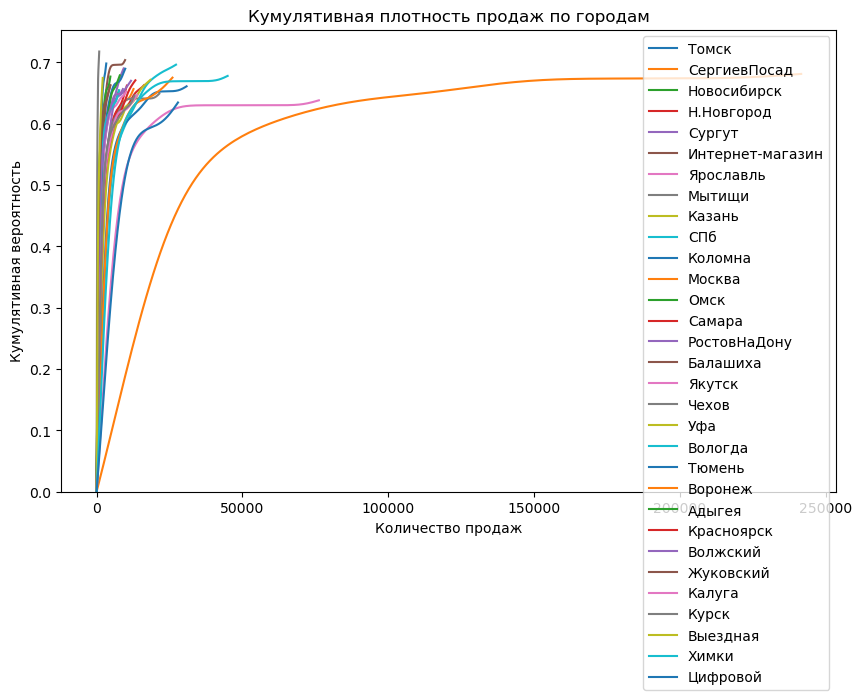

In [63]:
df = {
    'shop_city': df1.shop_city.to_numpy(),
    'item_cnt_day':  df1.item_cnt_day.to_numpy()
}

df = pd.DataFrame(df)

plt.figure(figsize=(10, 6))
for city in df['shop_city'].unique():
    sns.kdeplot(df[df['shop_city'] == city]['item_cnt_day'], cumulative=True, label=city, cut=0)

plt.title('Кумулятивная плотность продаж по городам')
plt.xlabel('Количество продаж')
plt.ylabel('Кумулятивная вероятность')
plt.legend()
plt.show()

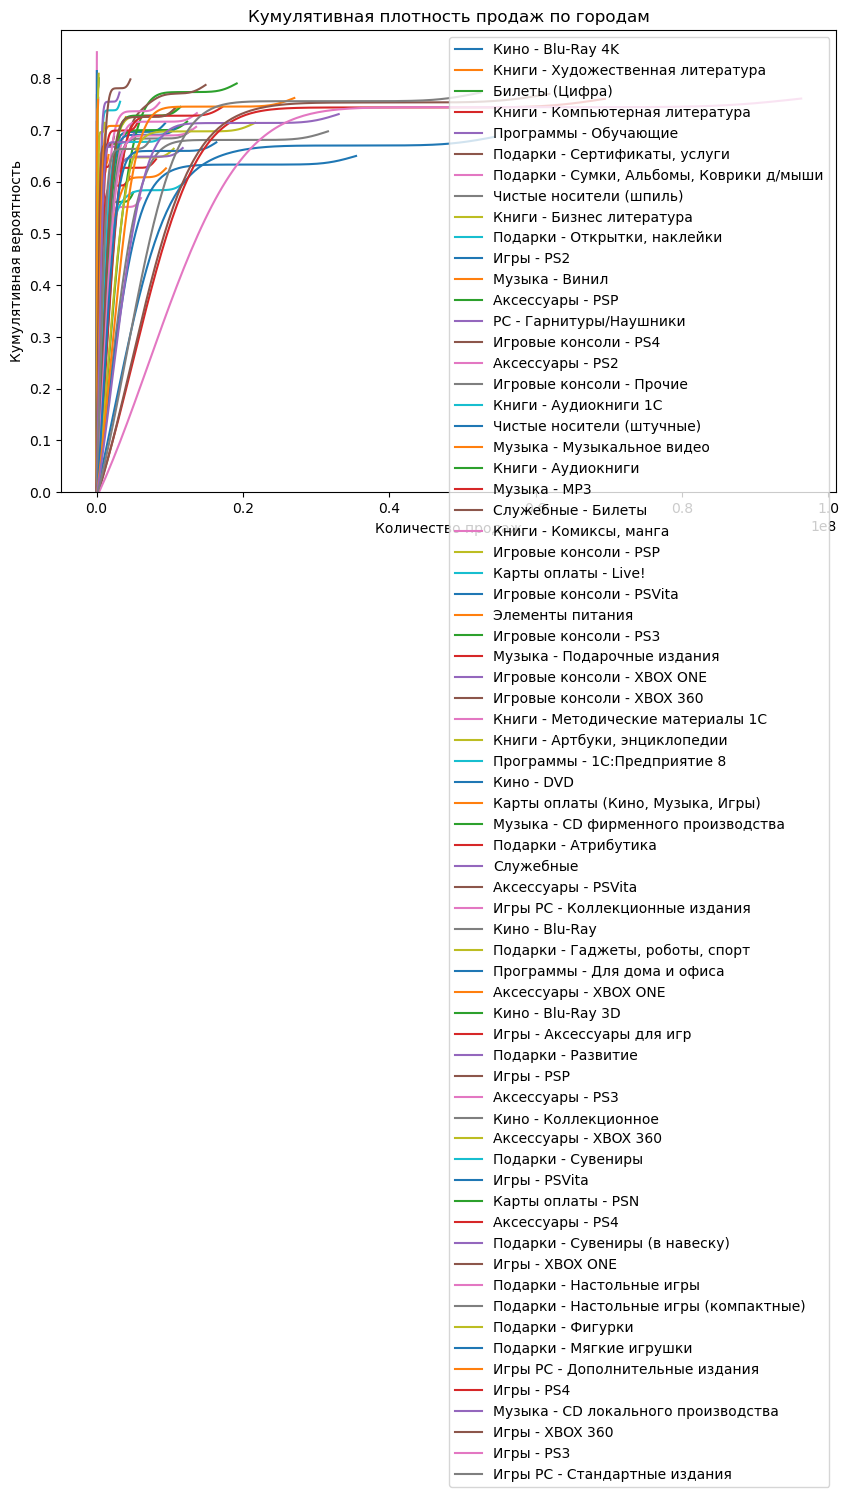

In [64]:
df = {
    'item_categories': df1.item_category_name.to_numpy(),
    'item_price':  df1.item_price.to_numpy()
}

df = pd.DataFrame(df)

plt.figure(figsize=(10, 6))
for city in df['item_categories'].unique():
    sns.kdeplot(df[df['item_categories'] == city]['item_price'], cumulative=True, label=city, cut=0)

plt.title('Кумулятивная плотность продаж по городам')
plt.xlabel('Количество продаж')
plt.ylabel('Кумулятивная вероятность')
plt.legend()
plt.show()


###### Correlation matrix

In [65]:
data['sales_train'].groupby(['date_block_num']).agg({'item_price': 'sum', 'item_id': 'count'}).corr()

item_price  item_id
item_price        1.00     0.77
item_id           0.77     1.00

As item counts and price of items have linear dependence it can go to the problem of multicollinearity so need to do smth with this labels in data preproccesing if we going to train linear model (like remove one of this label) 

Correlation is no equal to 1. Maybe it's cause of price change during the time

Check for change of price and if price has changed hot it affect on sales

In [66]:
price_changes = data['sales_train'].groupby('item_id')['item_price'].nunique().reset_index()

items_with_price_changes = price_changes[price_changes['item_price'] > 1].rename(columns={"item_price":"item_price_change"})

items_with_price_changes



item_id  item_price_change
3            3                  2
27          27                 11
28          28                 11
29          29                  6
30          30                 27
...        ...                ...
21755    22162                 10
21756    22163                  4
21757    22164                 11
21760    22167                  8
21761    22168                  2

[15850 rows x 2 columns]

It turns out there are a large number of products whose prices have changed over time. Perhaps there were some holidays or discounts or simply inflation that affected the price of goods, which in turn could affect their salability. It may be worth highlighting the change in the price of a product as a separate feature

Checked for items with no information

1. Number of good pairs: 111172
2. No data items: 15750
3. Only item_id info: 87278


[Text(0, 0, '0.5190'), Text(0, 0, '0.0735'), Text(0, 0, '0.4075')]

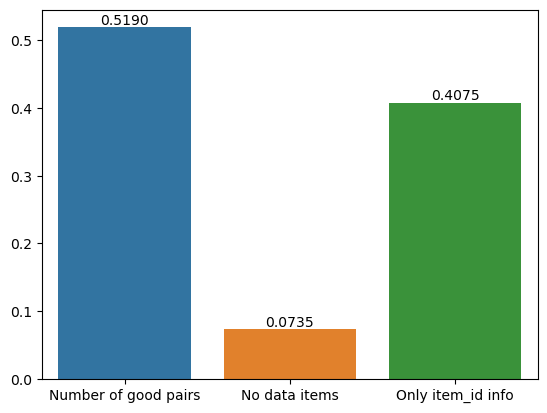

In [67]:
# calculating
good_sales = data['test'].merge(data['sales_train'], on=['item_id','shop_id'], how='left').dropna()
good_pairs = data['test'][data['test']['ID'].isin(good_sales['ID'])]
no_data_items = data['test'][~(data['test']['item_id'].isin(data['sales_train']['item_id']))]

# output
print('1. Number of good pairs:', len(good_pairs))
print('2. No data items:', len(no_data_items))
print('3. Only item_id info:', len(data['test'])-len(no_data_items)-len(good_pairs))

# visualization
d = { 'Number of good pairs': [len(good_pairs) / len(data['test'])],
      'No data items' : [len(no_data_items) / len(data['test'])],
      'Only item_id info' : [(len(data['test'])-len(no_data_items)-len(good_pairs)) / len(data['test'])]}
ax = sns.barplot(pd.DataFrame(d))
ax.bar_label(ax.containers[0], fmt='%.4f')

We have few items with no information (7.35%), and a lot of items for which we have sales information but not for a link to a specific shop, which we will need to predict (40.78%)

### Conclusions

1. In raw dataset, clearly see the time effect on sales (seasonality especially). 
2. Different categories of items have different marketability, so they were divided into several types (high-selling, medium-selling, low-selling and rarely selling)
3. Different categories of stores also have different marketability, but it is difficult to separate manually. Therefore, clustering was applied, which divided the stores by saleability based on the cosine distance into 3 categories
4. Clustered items by price
5. Based on the autocorrelation and partial autocorrelation graphs, it was customary to use lags of 1 month as useful features like a lag of [1, 2, 3, 12] for months and lag of [1, 4, 7, 52] for weeks
6. Months with the highest sales fall on the 9th, 10th, 11th, 12th month.
7. It turns out there are a large number of products whose prices have changed over time. Perhaps there were some holidays or discounts or simply inflation that affected the price of goods, which in turn could affect their salability. It may be worth highlighting the change in the price of a product as a separate feature
8. A lot of shops have really poor information of sales (maybe some shops closed in this 3 year interval or they are not popular at all). Maybe need to make a features like first sale of item and last sale of item.
9. No correlation between price of item and item sales (?)
10. There are multicollinearity based on items price and items count sales.
11. We have few items with no information (7.35%), and a lot of items for which we have sales information but not for a link to a specific shop, which we will need to predict (40.78%)

###### Saving data received during EDA

In [68]:
cluster_data = {
    'item_category_clusters' : item_category_clusters,
    'type_code_clusters' : type_code_clusters,
    'subtype_clusters' : subtype_clusters,
    'item_price_clusters' : item_price_clusters,
    'shop_clusters' : shop_clusters,
}

In [69]:
%%time

# get directory path
dirpath = os.getcwd()

# set the data path
path_to_load = Path(dirpath) / 'data' / 'cluster_data'
print(path_to_load)
print(type(path_to_load))
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in cluster_data.items():
    filepath = path_to_load / (filename + ".csv")
    df.to_csv(filepath, index=False)

C:\Repository\DS-Intership\data\cluster_data
<class 'pathlib.WindowsPath'>
CPU times: total: 1.38 s
Wall time: 2.11 s


In [71]:
from os import listdir
from os.path import isfile, join
print(*[f+"\n" for f in listdir(path_to_load) if isfile(join(path_to_load, f))])

item_category_clusters.csv
 item_price_clusters.csv
 shop_clusters.csv
 subtype_clusters.csv
 type_code_clusters.csv

